In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
bernoulli = np.repeat([0, 1], 100)
categorical = np.repeat([0, 1], 100)

In [4]:
df = pd.DataFrame({"bernoulli": bernoulli, "categorical": categorical})

In [5]:
from inferenceql_auto_modeling.cgpm import CGPMModel

In [6]:
schema = {"bernoulli": "bernoulli", "categorical": "categorical"}

In [7]:
mapping_table = {"categorical": {"false": 0, "true": 1}}

In [8]:
additional_metadata = {
    "Zrv": {0: np.repeat([0, 1], 100)},
}

In [10]:
wrapper = CGPMModel.from_data(
    df, schema, mapping_table, model="DPMM", additional_metadata=additional_metadata
)

In [54]:
bernoulli_dim = wrapper.cgpm.dim_for(0)
categorical_dim = wrapper.cgpm.dim_for(1)

grid = bernoulli_dim.hyper_grids

In [27]:
from inferenceql_auto_modeling.grid_refinement import get_logp, set_hyper, refine_grid

In [16]:
def get_posterior(dim, hyper, grid):
    posterior = np.array([get_logp(bernoulli_dim, hyper, val) for val in grid])

    return posterior

In [36]:
def reset_hypers(state):
    set_hyper(state.crp, "alpha", 1)
    set_hyper(state.views[0].crp, "alpha", 1)

    set_hyper(state.dim_for(0), "alpha", 1)
    set_hyper(state.dim_for(0), "beta", 1)
    set_hyper(state.dim_for(1), "alpha", 1)

In [61]:
n_grid = len(grid["alpha"])

def get_beta_posterior(bernoulli_dim):
    alphas = np.zeros(n_grid * n_grid)
    betas = np.zeros(n_grid * n_grid)
    posterior = np.zeros(n_grid * n_grid)
    for i, beta_val in tqdm(enumerate(grid["beta"])):
        set_hyper(bernoulli_dim, "beta", beta_val)
        posterior[i*n_grid: (i+1) * n_grid] = get_posterior(bernoulli_dim, "alpha", grid["alpha"])
        alphas[i*n_grid: (i+1) * n_grid] = grid["alpha"]
        betas[i*n_grid: (i+1) * n_grid] = beta_val

    posterior = np.exp(posterior)
    posterior /= sum(posterior)
    
    return pd.DataFrame({
        "log_alpha": np.log(alphas),
        "log_beta": np.log(betas),
        "posterior": posterior
    })

In [62]:
df = get_beta_posterior(bernoulli_dim)

30it [00:00, 5264.38it/s]


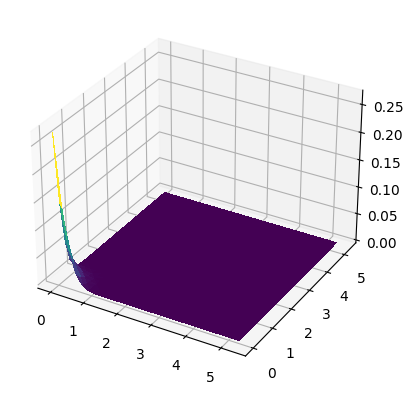

In [64]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_trisurf(df['log_alpha'], df['log_beta'], df['posterior'], cmap=cm.viridis,
                       linewidth=0, antialiased=False)

In [25]:
reset_hypers(wrapper.cgpm)

wrapper.cgpm.transition_dim_hypers()

In [26]:
bernoulli_dim.hypers

{'alpha': 1.2004549366776545, 'beta': 1.2004549366776545}

In [65]:
reset_hypers(wrapper.cgpm)
new_grid = refine_grid(wrapper.cgpm)

In [66]:
wrapper.set_hyper_grids(new_grid)

In [91]:
reset_hypers(wrapper.cgpm)
wrapper.inference(N=100, kernels=["column_hypers"])

Completed: 100 iterations in 0.026657 minutes.


In [92]:
grid = bernoulli_dim.hyper_grids
grid

{'alpha': array([1.e-10]), 'beta': array([1.e-10])}

In [94]:
categorical_dim.hyper_grids

{'alpha': array([2.89667968e-10])}

In [68]:
df = get_beta_posterior(bernoulli_dim)

30it [00:00, 5411.07it/s]


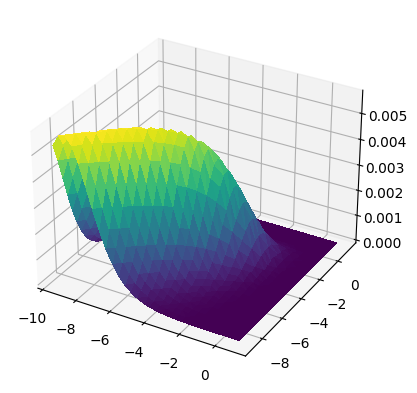

In [69]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_trisurf(df['log_alpha'], df['log_beta'], df['posterior'], cmap=cm.viridis,
                       linewidth=0, antialiased=False)